# Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import os
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

# Dataset

## data path

In [4]:
path = '/content/bank_customer_transactions.csv'

## Data cleaning function

In [5]:
def clean_encoding(text):
    return (text.replace('+AC0-', '-')
                .replace('+ACI-', '"')
                .replace('+ACU-', "'")
                .replace('\n', '')
                .strip())

with open(path, 'r') as f:
    with open('bank_customer_transactions_edited.csv', 'w') as f_new:
        for i, line in enumerate(f):
            line = clean_encoding(line)
            line = line.replace('"', '')
            parts = line.strip().split(',')

            if i == 0:
                f_new.write(','.join(parts) + '\n')
            else:
                first_nine = parts[:9]
                remaining = parts[9:]
                cleaned_remaining = '_ '.join([item for item in remaining])
                f_new.write(','.join(first_nine) + ',' + cleaned_remaining + '\n')

f.close()
f_new.close()

## Read the cleaned data csv

In [2]:
data = pd.read_csv('bank_customer_transactions_edited.csv')

## Show data head

In [3]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,credit card_ loans_ savings
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,tds
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0,loans_ savings
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0,long term investment_ savings
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,loans_ savings


## Data info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9881 entries, 0 to 9880
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            9881 non-null   object 
 1   CustomerID               9881 non-null   object 
 2   CustomerDOB              9847 non-null   object 
 3   CustGender               9878 non-null   object 
 4   CustLocation             9880 non-null   object 
 5   CustAccountBalance       9867 non-null   object 
 6   TransactionDate          9881 non-null   object 
 7   TransactionTime          9881 non-null   object 
 8   TransactionAmount (INR)  9880 non-null   float64
 9   OwnedProducts            9702 non-null   object 
dtypes: float64(1), object(9)
memory usage: 772.1+ KB


## Convert and construct date type columns

In [5]:
data['CustomerDOB'] = pd.to_datetime(data['CustomerDOB'])
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], format='%d/%m/%y', errors='coerce')

In [6]:
data.dropna(axis=0, inplace=True)

In [7]:
def combine_date_time(row):
    date_str = row['TransactionDate'].strftime('%Y-%m-%d')
    time_str = str(int(row['TransactionTime'])).zfill(6)
    return datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H%M%S")

In [8]:
data['FullTransactionDatetime'] = data.apply(combine_date_time, axis=1)

In [9]:
data['CustAccountBalance'] = pd.to_numeric(data['CustAccountBalance'])

In [10]:
data.drop(columns=['TransactionDate', 'TransactionTime'], inplace=True)

In [11]:
data.reset_index(inplace=True)

In [12]:
data.drop(columns=['index'], inplace=True)

## Show data info

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9663 entries, 0 to 9662
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TransactionID            9663 non-null   object        
 1   CustomerID               9663 non-null   object        
 2   CustomerDOB              9663 non-null   datetime64[ns]
 3   CustGender               9663 non-null   object        
 4   CustLocation             9663 non-null   object        
 5   CustAccountBalance       9663 non-null   float64       
 6   TransactionAmount (INR)  9663 non-null   float64       
 7   OwnedProducts            9663 non-null   object        
 8   FullTransactionDatetime  9663 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 679.6+ KB


## Owned product column

In [14]:
data['OwnedProducts_split'] = data['OwnedProducts'].apply(lambda x: [item.strip() for item in x.split('_') if item.strip()])

In [15]:
mlb = MultiLabelBinarizer()
owned_products_encoded = pd.DataFrame(mlb.fit_transform(data['OwnedProducts_split']),
                                      columns=mlb.classes_,
                                      index=data.index)

data.drop(columns=['OwnedProducts_split', 'OwnedProducts'], inplace=True)

### reduce owned product to 3 columns


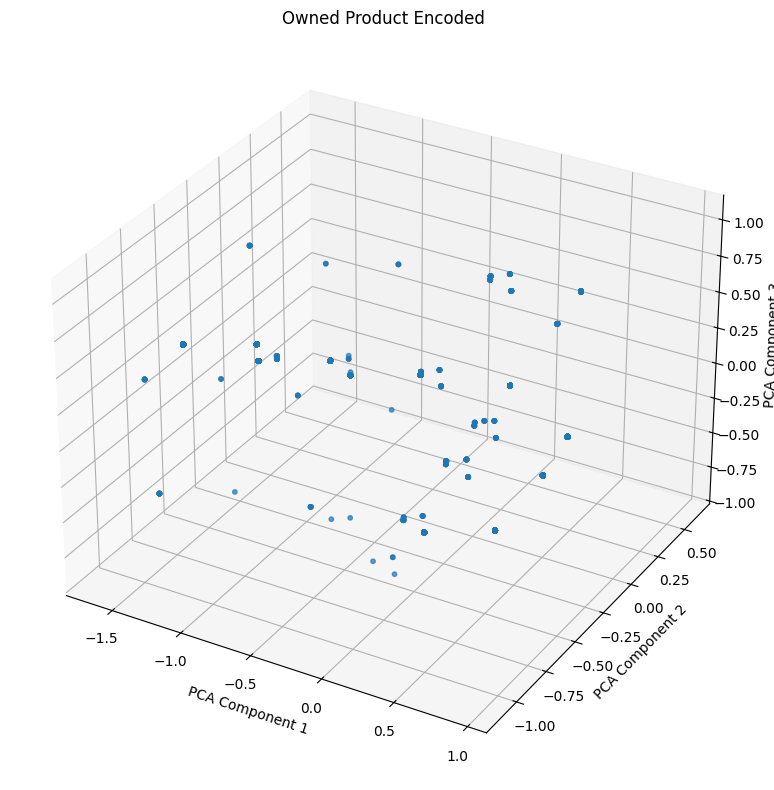

In [33]:
X = owned_products_encoded

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

data['pca-1'] = X_pca[:, 0]
data['pca-2'] = X_pca[:, 1]
data['pca-3'] = X_pca[:, 2]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], cmap='tab10', s=10, alpha=0.7)

ax.set_title('Owned Product Encoded')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.tight_layout()
plt.show()

## Transform gender column

In [20]:
gender_encoded = pd.get_dummies(data['CustGender'], prefix='Gender', dtype=float)
data = pd.concat([data, gender_encoded], axis=1)
data.drop(columns=['CustGender'], inplace=True)

## Transform Location to frequancy embedding style

In [21]:
location_freq = data['CustLocation'].value_counts().to_dict()
data['LocationFreq'] = data['CustLocation'].map(location_freq)
data.drop(columns=['CustLocation'], inplace=True)

# Customer Dataframe

## Group by Customer and Features construction

In [22]:
data["CustAccountBalance_log"] = np.log1p(data["CustAccountBalance"])
data["TransactionAmount_log"] = np.log1p(data["TransactionAmount (INR)"])
data["LocationFreq_log"] = np.log1p(data["LocationFreq"])
customer_df = data.groupby('CustomerID').agg({
    'CustAccountBalance': ['mean', 'median', 'first', 'last'],
    'CustAccountBalance_log': ['mean'],
    'TransactionAmount_log': ['mean'],
    'TransactionAmount (INR)': ['mean', 'sum',  'max', 'count'],
    'pca-1': 'mean',
    'pca-2': 'mean',
    'pca-3': 'mean',
    'Gender_F': 'first',
    'Gender_M': 'first',
    'LocationFreq': 'mean',
    'LocationFreq_log': 'mean',
    'CustomerDOB': 'first',
    'FullTransactionDatetime': ['first', 'last'],
})

In [23]:
customer_df.columns = ['_'.join(col).strip() for col in customer_df.columns.values]
customer_df.reset_index(inplace=True)

In [24]:
today = pd.Timestamp(datetime.today())
customer_df['Age'] = (today - customer_df['CustomerDOB_first']).dt.days // 365
customer_df.drop(columns=['CustomerDOB_first'], inplace=True)

In [25]:
customer_df['Recency'] = (today - customer_df['FullTransactionDatetime_last']).dt.days
customer_df.fillna({
    'Age': customer_df['Age'].median(),
}, inplace=True)

## Show customer dataframe

In [26]:
customer_df.head()

,CustomerID,CustAccountBalance_mean,CustAccountBalance_median,CustAccountBalance_first,CustAccountBalance_last,CustAccountBalance_log_mean,TransactionAmount_log_mean,TransactionAmount (INR)_mean,TransactionAmount (INR)_sum,TransactionAmount (INR)_max,...,pca-2_mean,pca-3_mean,Gender_F_first,Gender_M_first,LocationFreq_mean,LocationFreq_log_mean,FullTransactionDatetime_first,FullTransactionDatetime_last,Age,Recency
0,C1010245,4668.96,4668.96,4668.96,4668.96,8.448906,5.707110,300.00,300.00,300.00,...,-0.573294,0.140917,0.0,1.0,281.0,5.641907,2016-09-22 15:28:11,2016-09-22 15:28:11,37,3137
1,C1011072,128634.09,128634.09,128634.09,128634.09,11.764735,4.615121,100.00,100.00,100.00,...,-0.226269,0.133245,0.0,1.0,35.0,3.583519,2016-10-21 15:05:49,2016-10-21 15:05:49,35,3108
2,C1011148,2454.70,2454.70,2454.70,2454.70,7.806167,5.225747,185.00,185.00,185.00,...,-0.573294,0.140917,0.0,1.0,3.0,1.386294,2016-09-25 19:51:21,2016-09-25 19:51:21,40,3134
3,C1011359,179.99,179.99,179.99,179.99,5.198442,6.862758,955.00,955.00,955.00,...,-0.573294,0.140917,0.0,1.0,281.0,5.641907,2016-08-09 03:06:19,2016-08-09 03:06:19,30,3182
4,C1011541,230.31,230.31,230.31,230.31,5.443759,4.927833,137.08,137.08,137.08,...,-0.573294,0.140917,0.0,1.0,114.0,4.744932,2016-09-26 21:05:45,2016-09-26 21:05:45,35,3133


In [27]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CustomerID                     9641 non-null   object        
 1   CustAccountBalance_mean        9641 non-null   float64       
 2   CustAccountBalance_median      9641 non-null   float64       
 3   CustAccountBalance_first       9641 non-null   float64       
 4   CustAccountBalance_last        9641 non-null   float64       
 5   CustAccountBalance_log_mean    9641 non-null   float64       
 6   TransactionAmount_log_mean     9641 non-null   float64       
 7   TransactionAmount (INR)_mean   9641 non-null   float64       
 8   TransactionAmount (INR)_sum    9641 non-null   float64       
 9   TransactionAmount (INR)_max    9641 non-null   float64       
 10  TransactionAmount (INR)_count  9641 non-null   int64         
 11  pca-1_mean       

## Remove the unreal values from age column

In [28]:
customer_df = customer_df[customer_df['Age'] <= 100]

In [29]:
customer_df = customer_df[customer_df['Age'] >= 16]

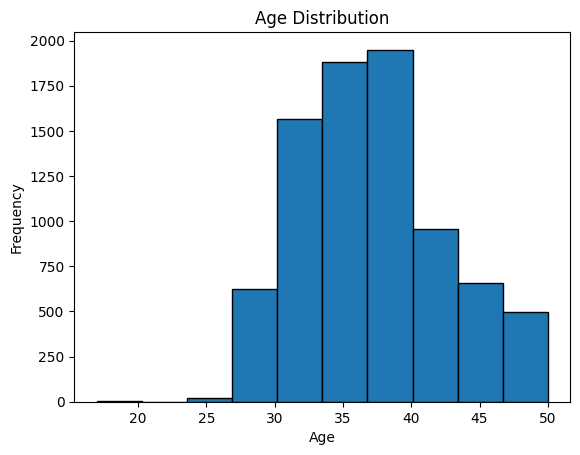

In [32]:
plt.hist(customer_df['Age'], edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [34]:
customer_df['Age'].describe()

count    8155.000000
mean       37.166524
std         5.210316
min        17.000000
25%        33.000000
50%        36.000000
75%        41.000000
max        50.000000
Name: Age, dtype: float64

In [35]:
customer_df.describe()

,CustAccountBalance_mean,CustAccountBalance_median,CustAccountBalance_first,CustAccountBalance_last,CustAccountBalance_log_mean,TransactionAmount_log_mean,TransactionAmount (INR)_mean,TransactionAmount (INR)_sum,TransactionAmount (INR)_max,TransactionAmount (INR)_count,...,pca-2_mean,pca-3_mean,Gender_F_first,Gender_M_first,LocationFreq_mean,LocationFreq_log_mean,FullTransactionDatetime_first,FullTransactionDatetime_last,Age,Recency
count,8.155000e+03,8.155000e+03,8.155000e+03,8.155000e+03,8155.000000,8155.000000,8155.000000,8155.000000,8155.000000,8155.000000,...,8155.000000,8155.000000,8155.000000,8155.000000,8155.000000,8155.000000,8155,8155,8155.000000,8155.00000
mean,8.302106e+04,8.302106e+04,8.291771e+04,8.312441e+04,9.473190,5.905504,1448.629617,1453.630180,1452.028218,1.002085,...,0.018121,0.079777,0.283752,0.716248,361.398835,4.613632,2016-10-01 21:14:01.494543104,2016-10-01 20:47:32.627099648,37.166524,3127.96260
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,-1.121599,-0.881169,0.000000,0.000000,1.000000,0.693147,2016-08-01 08:22:53,2016-08-01 08:22:53,17.000000,3108.00000
25%,5.189995e+03,5.189995e+03,5.173160e+03,5.161980e+03,8.549269,4.997212,147.000000,147.000000,147.000000,1.000000,...,-0.504918,-0.106661,0.000000,0.000000,13.000000,2.639057,2016-09-22 14:24:47,2016-09-22 14:24:59,33.000000,3108.00000
50%,1.714697e+04,1.714697e+04,1.714697e+04,1.713353e+04,9.749157,5.940171,379.000000,380.000000,379.200000,1.000000,...,-0.001406,0.140917,0.000000,1.000000,220.000000,5.398163,2016-09-25 21:21:04,2016-09-25 21:20:54,36.000000,3134.00000
75%,5.230568e+04,5.230568e+04,5.227849e+04,5.217109e+04,10.864359,6.908755,1000.000000,1000.000000,1000.000000,1.000000,...,0.572364,0.361934,1.000000,1.000000,761.000000,6.635947,2016-10-21 16:51:08.500000,2016-10-21 16:49:18.500000,41.000000,3137.00000
max,2.169666e+07,2.169666e+07,2.169666e+07,2.169666e+07,16.892669,13.028323,455122.000000,455122.000000,455122.000000,2.000000,...,0.615275,1.029202,1.000000,1.000000,981.000000,6.889591,2016-10-21 22:48:48,2016-10-21 22:48:48,50.000000,3190.00000
std,3.684848e+05,3.684848e+05,3.682280e+05,3.694976e+05,2.325934,1.584921,7774.587064,7784.640303,7780.176849,0.045613,...,0.490017,0.263149,0.450846,0.450846,361.361645,2.137054,NaN,NaN,5.210316,18.07103


## Show data columns plots

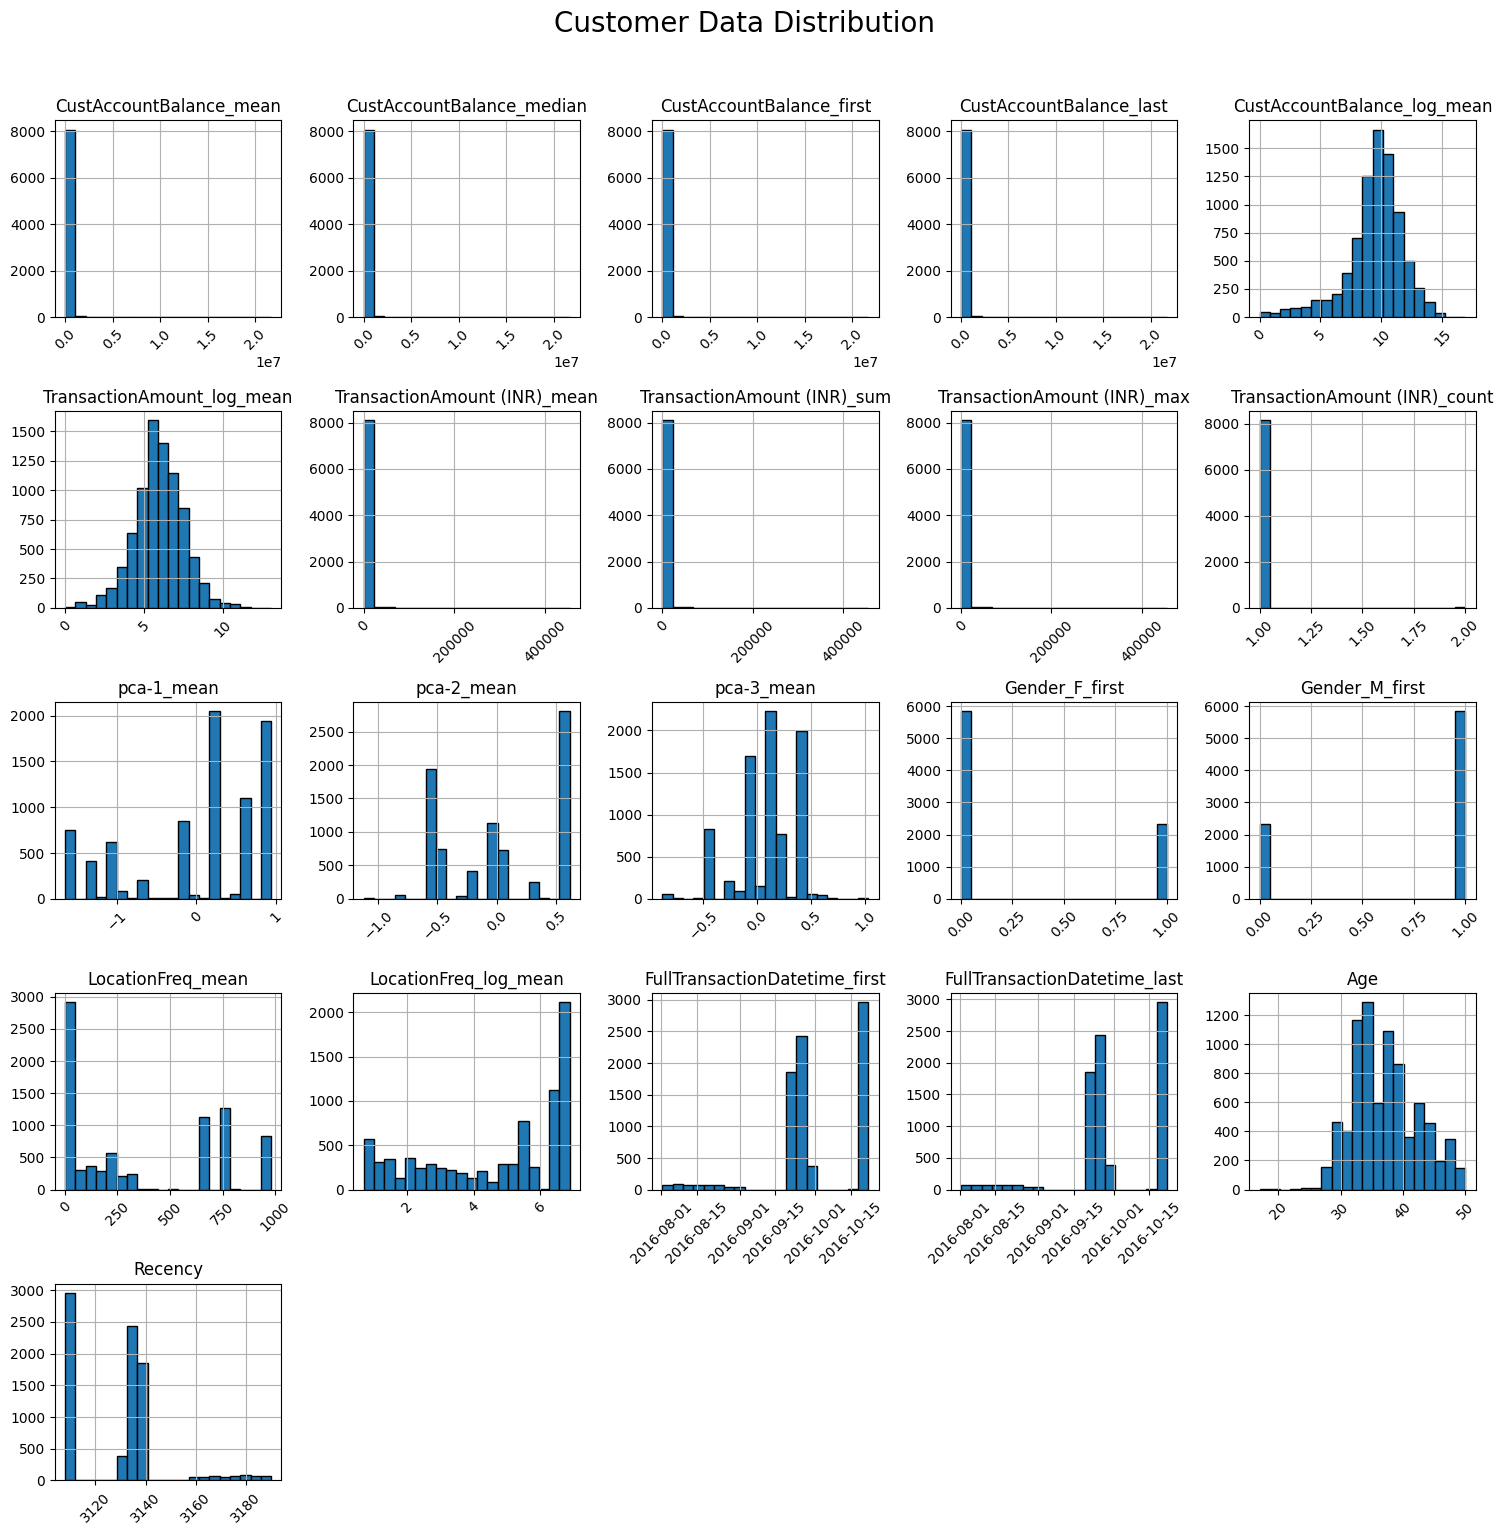

In [41]:
customer_df.hist(figsize=(15, 15), edgecolor='black', xrot=45, bins=20)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Customer Data Distribution', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## Remove outliers

In [56]:
def remove_outliers_iqr(df, multiplier=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ~((df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))).any(axis=1)
    return df[outlier_mask]

In [57]:
X_no_outliers = remove_outliers_iqr(customer_df.drop(columns='CustomerID'), multiplier=1.5)

### Plot the columns after removing outliers

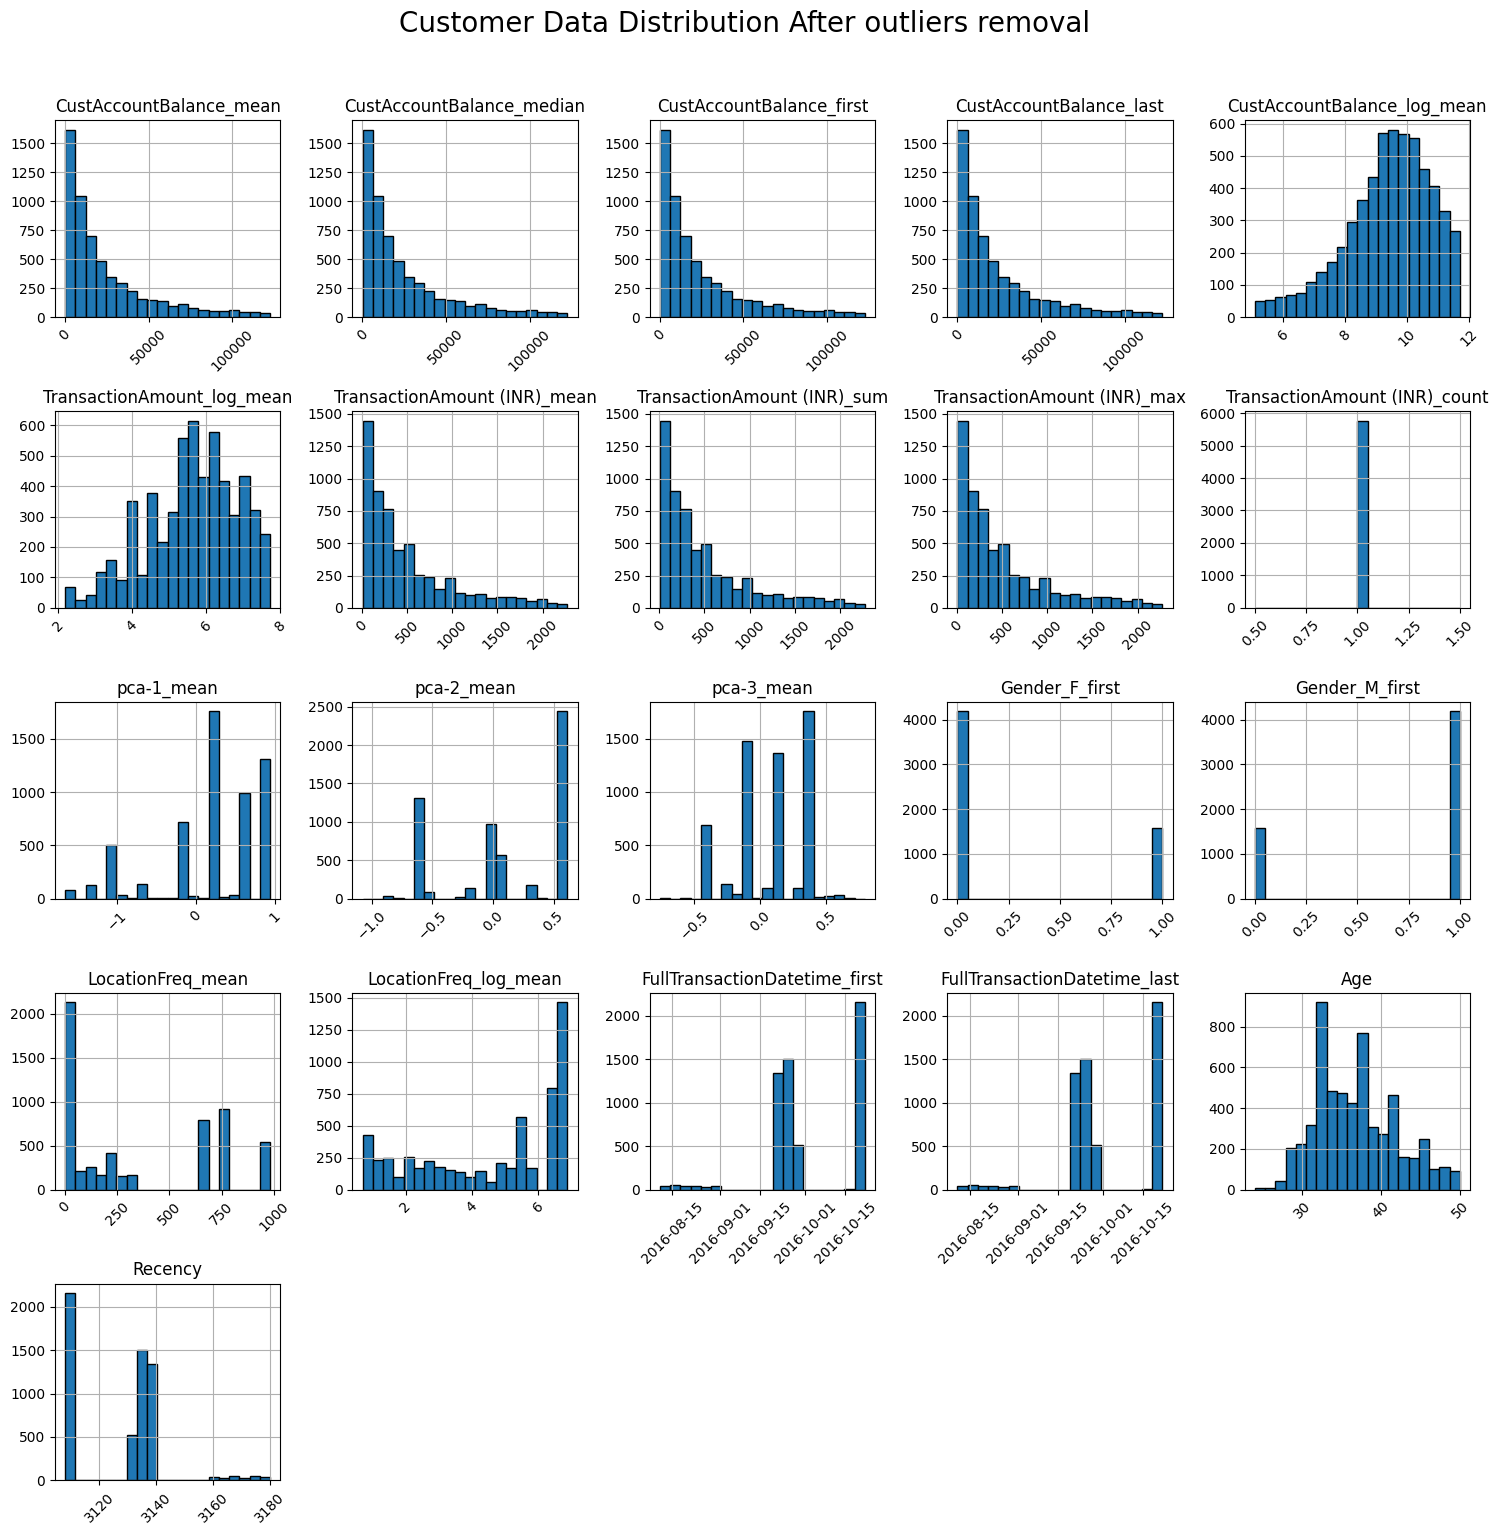

In [58]:
X_no_outliers.hist(figsize=(15, 15), edgecolor='black', xrot=45, bins=20)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Customer Data Distribution After outliers removal', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## Feature selection

### show the correlation between columns

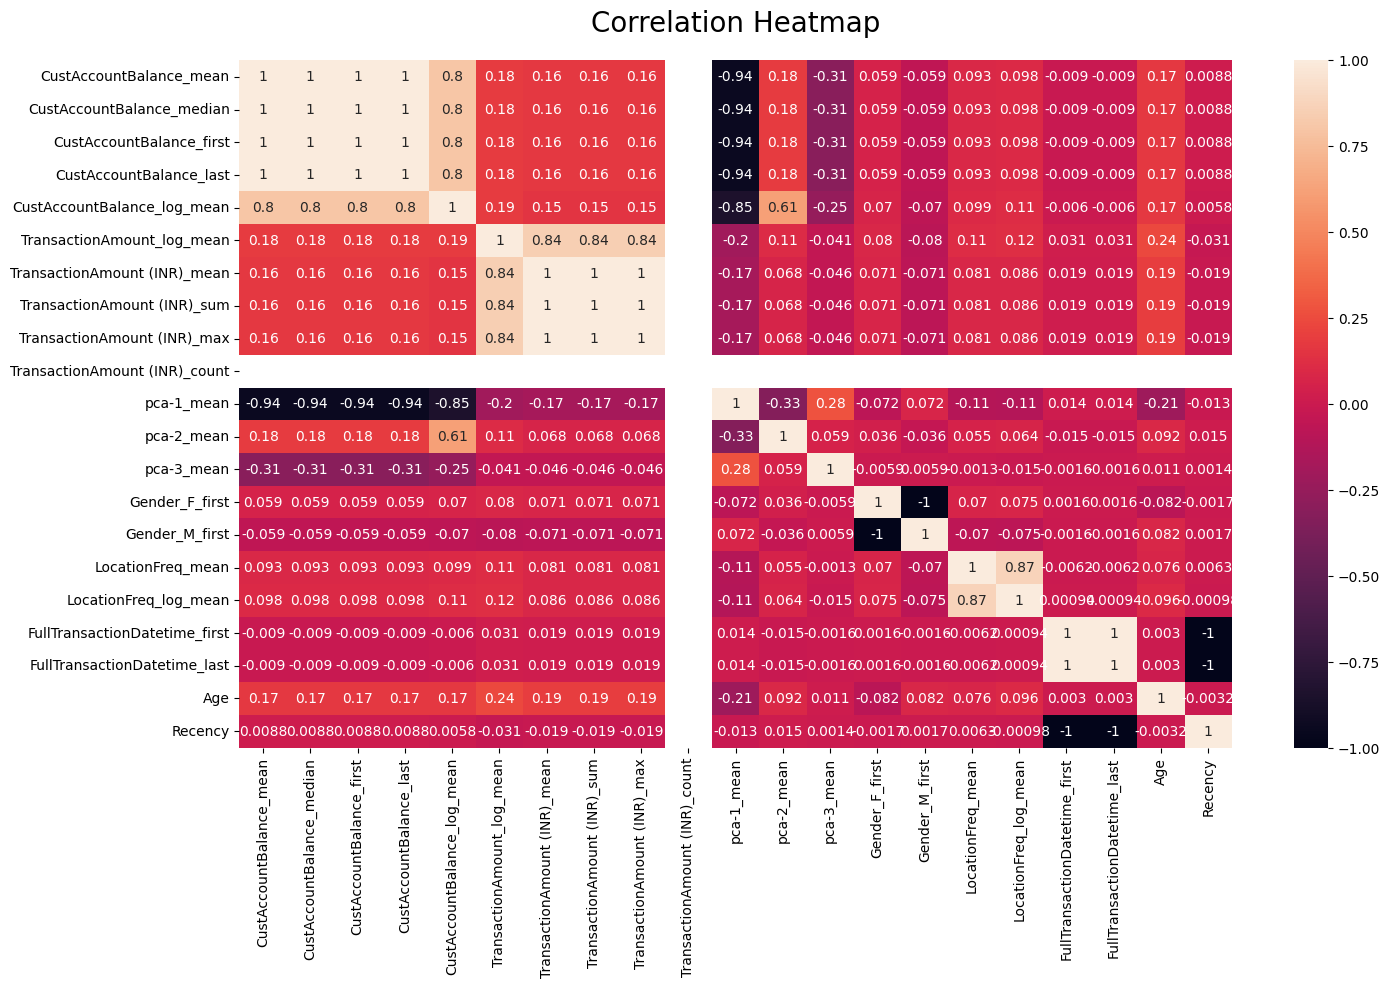

In [71]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_no_outliers.corr(), annot=True, vmax=1, vmin=-1)
plt.title('Correlation Heatmap', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

### Select features with lower correlation

In [72]:
features = [
    'CustAccountBalance_mean',
    'TransactionAmount (INR)_mean',
    'pca-2_mean',
    'pca-3_mean',
    'Gender_F_first',
    'LocationFreq_log_mean',
    'Age',
    'Recency',
]

X = X_no_outliers[features]

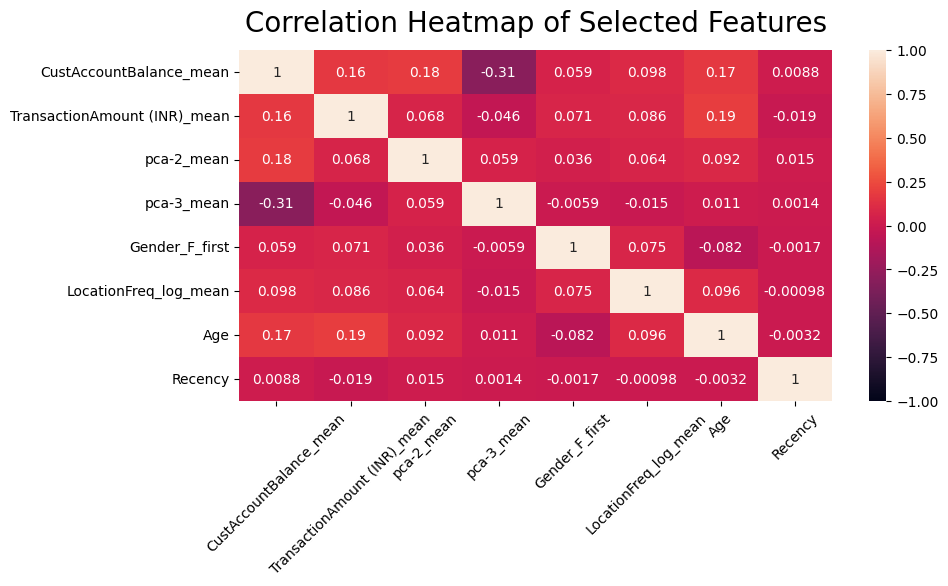

In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)
plt.title('Correlation Heatmap of Selected Features', fontsize=20, y=1.03)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scale the data columns

In [76]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.dropna())

# Kmeans Clusters

In [77]:
k_mean = KMeans(n_clusters=4, random_state=43)
k_mean_labels = k_mean.fit_predict(X_scaled)

X_no_outliers['KMeans_Cluster'] = k_mean_labels

## Plot Clusters

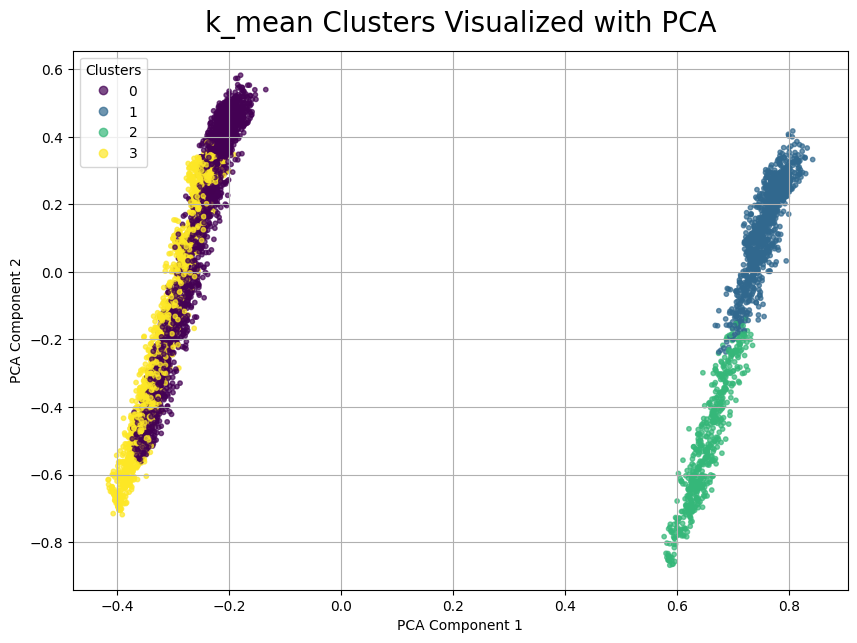

In [78]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=k_mean_labels, s=10, alpha=0.7)
plt.title('k_mean Clusters Visualized with PCA', fontsize=20, y=1.02)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

## Plot Clusters in 3D

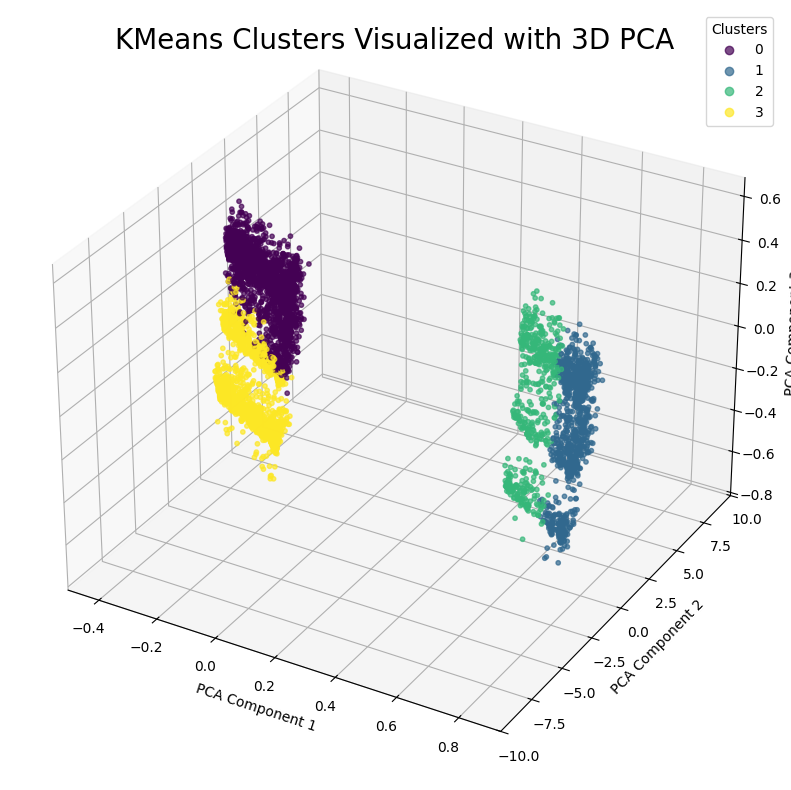

In [79]:
pca_vis = PCA(n_components=3)
X_vis = pca_vis.fit_transform(X_scaled)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], X_vis[:, 2],
                     c=k_mean_labels, s=10, alpha=0.7)

ax.set_ylim(-10, 10)

ax.set_title('KMeans Clusters Visualized with 3D PCA', fontsize=20, y=1.02)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()